Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:05<00:00, 28947989.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


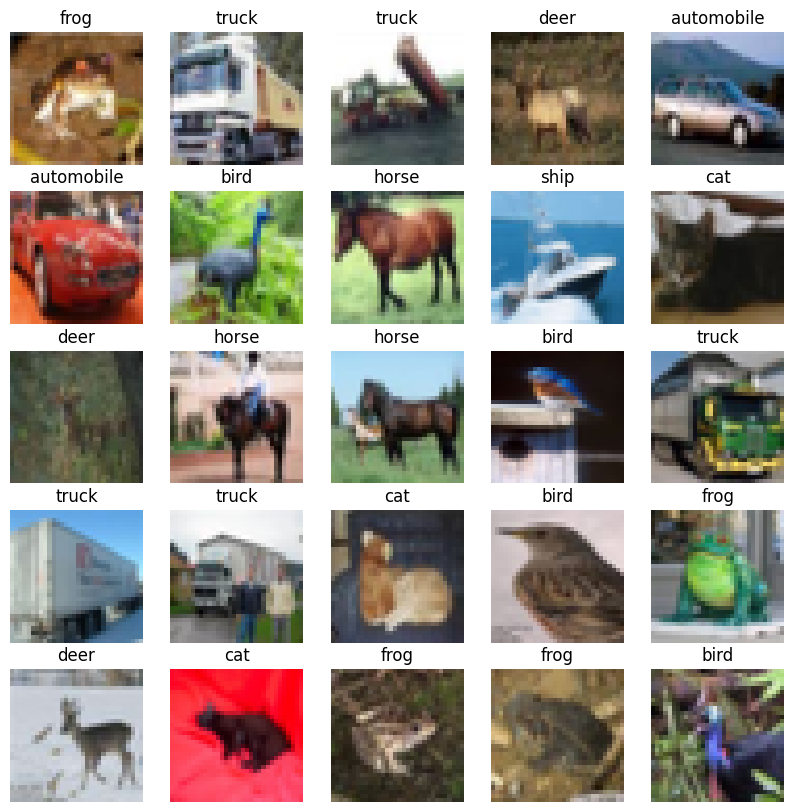

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)
  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)




Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:57<4:48:31, 57.90s/it]

Training Loss : 2.715130953979492, Testing Loss : 3.3745434284210205, Training Accuracy : 0.10816, Testing Accuracy : 0.1154


  1%|          | 2/300 [01:49<4:28:24, 54.04s/it]

Training Loss : 2.38140337310791, Testing Loss : 2.4197433486938476, Training Accuracy : 0.11994, Testing Accuracy : 0.1341


  1%|          | 3/300 [02:40<4:22:10, 52.96s/it]

Training Loss : 2.4580389126586915, Testing Loss : 2.575476663970947, Training Accuracy : 0.11194, Testing Accuracy : 0.1


  1%|▏         | 4/300 [03:30<4:15:29, 51.79s/it]

Training Loss : 2.4769410018920897, Testing Loss : 2.5535836334228517, Training Accuracy : 0.10546, Testing Accuracy : 0.1


  2%|▏         | 5/300 [04:22<4:13:28, 51.55s/it]

Training Loss : 2.551862571105957, Testing Loss : 2.514119116973877, Training Accuracy : 0.10024, Testing Accuracy : 0.1


  2%|▏         | 6/300 [05:13<4:12:23, 51.51s/it]

Training Loss : 2.488847565612793, Testing Loss : 2.6773925605773927, Training Accuracy : 0.09996, Testing Accuracy : 0.1


  2%|▏         | 7/300 [06:04<4:10:31, 51.30s/it]

Training Loss : 2.5622118829345704, Testing Loss : 2.547692264556885, Training Accuracy : 0.10158, Testing Accuracy : 0.0999


  3%|▎         | 8/300 [06:54<4:08:12, 51.00s/it]

Training Loss : 2.5553444647216796, Testing Loss : 2.5650420951843262, Training Accuracy : 0.10186, Testing Accuracy : 0.0954


  3%|▎         | 9/300 [07:45<4:07:15, 50.98s/it]

Training Loss : 2.5011448428344725, Testing Loss : 2.4338040222167967, Training Accuracy : 0.10426, Testing Accuracy : 0.1001


  3%|▎         | 10/300 [08:35<4:05:26, 50.78s/it]

Training Loss : 2.42362944732666, Testing Loss : 2.4103249450683593, Training Accuracy : 0.1052, Testing Accuracy : 0.1001


  4%|▎         | 11/300 [09:25<4:03:17, 50.51s/it]

Training Loss : 2.394496202392578, Testing Loss : 2.456159178161621, Training Accuracy : 0.09946, Testing Accuracy : 0.1


  4%|▍         | 12/300 [10:16<4:03:06, 50.65s/it]

Training Loss : 2.4371820330810547, Testing Loss : 2.486841981124878, Training Accuracy : 0.10232, Testing Accuracy : 0.1


  4%|▍         | 13/300 [11:07<4:02:31, 50.70s/it]

Training Loss : 2.4598793353271486, Testing Loss : 2.541819370651245, Training Accuracy : 0.10094, Testing Accuracy : 0.0795


  5%|▍         | 14/300 [11:59<4:03:26, 51.07s/it]

Training Loss : 2.408065910949707, Testing Loss : 2.6837291130065917, Training Accuracy : 0.1031, Testing Accuracy : 0.0954


  5%|▌         | 15/300 [12:48<3:59:20, 50.39s/it]

Training Loss : 2.449399850769043, Testing Loss : 2.596907884979248, Training Accuracy : 0.10088, Testing Accuracy : 0.1


  5%|▌         | 16/300 [13:38<3:57:41, 50.22s/it]

Training Loss : 2.5361296841430665, Testing Loss : 2.604087477493286, Training Accuracy : 0.09898, Testing Accuracy : 0.1


  6%|▌         | 17/300 [14:27<3:56:04, 50.05s/it]

Training Loss : 2.5591898345947266, Testing Loss : 2.520186125946045, Training Accuracy : 0.0976, Testing Accuracy : 0.1


  6%|▌         | 18/300 [15:16<3:53:09, 49.61s/it]

Training Loss : 2.456825739440918, Testing Loss : 2.4228607471466064, Training Accuracy : 0.10226, Testing Accuracy : 0.1


  6%|▋         | 19/300 [16:06<3:52:39, 49.68s/it]

Training Loss : 2.3941184368896486, Testing Loss : 2.483175835418701, Training Accuracy : 0.10018, Testing Accuracy : 0.1


  7%|▋         | 20/300 [16:56<3:52:33, 49.83s/it]

Training Loss : 2.4373175198364256, Testing Loss : 2.5364774612426757, Training Accuracy : 0.09854, Testing Accuracy : 0.1


  7%|▋         | 21/300 [17:45<3:51:11, 49.72s/it]

Training Loss : 2.492419517211914, Testing Loss : 2.493063903427124, Training Accuracy : 0.10048, Testing Accuracy : 0.1


  7%|▋         | 22/300 [18:34<3:49:26, 49.52s/it]

Training Loss : 2.46571966217041, Testing Loss : 2.47228013420105, Training Accuracy : 0.1005, Testing Accuracy : 0.1


  8%|▊         | 23/300 [19:24<3:48:27, 49.48s/it]

Training Loss : 2.4657333337402343, Testing Loss : 2.4943892219543455, Training Accuracy : 0.10066, Testing Accuracy : 0.1


  8%|▊         | 24/300 [20:13<3:47:06, 49.37s/it]

Training Loss : 2.428536701965332, Testing Loss : 2.4889168365478516, Training Accuracy : 0.09922, Testing Accuracy : 0.1


  8%|▊         | 25/300 [21:02<3:45:59, 49.31s/it]

Training Loss : 2.4503496673583984, Testing Loss : 2.464559104537964, Training Accuracy : 0.10044, Testing Accuracy : 0.1


  9%|▊         | 26/300 [21:52<3:45:33, 49.39s/it]

Training Loss : 2.430100375366211, Testing Loss : 2.4892698055267335, Training Accuracy : 0.10062, Testing Accuracy : 0.1


  9%|▉         | 27/300 [22:41<3:45:03, 49.46s/it]

Training Loss : 2.460319540710449, Testing Loss : 2.5242444850921633, Training Accuracy : 0.09942, Testing Accuracy : 0.1


  9%|▉         | 28/300 [23:32<3:45:12, 49.68s/it]

Training Loss : 2.484167915649414, Testing Loss : 2.5253776546478273, Training Accuracy : 0.10052, Testing Accuracy : 0.1


 10%|▉         | 29/300 [24:20<3:43:08, 49.40s/it]

Training Loss : 2.485226541748047, Testing Loss : 2.5760029998779297, Training Accuracy : 0.10128, Testing Accuracy : 0.1


 10%|█         | 30/300 [25:10<3:43:06, 49.58s/it]

Training Loss : 2.496204722595215, Testing Loss : 2.5140042751312257, Training Accuracy : 0.099, Testing Accuracy : 0.1


 10%|█         | 31/300 [26:00<3:42:45, 49.69s/it]

Training Loss : 2.4622269116210935, Testing Loss : 2.5894371326446532, Training Accuracy : 0.09776, Testing Accuracy : 0.1


 11%|█         | 32/300 [26:50<3:41:49, 49.66s/it]

Training Loss : 2.5168591888427736, Testing Loss : 27.355010385131838, Training Accuracy : 0.10302, Testing Accuracy : 0.1


 11%|█         | 33/300 [27:40<3:41:01, 49.67s/it]

Training Loss : 2.445041045227051, Testing Loss : 2.541330227279663, Training Accuracy : 0.10754, Testing Accuracy : 0.1006


 11%|█▏        | 34/300 [28:29<3:40:17, 49.69s/it]

Training Loss : 2.4870054956054686, Testing Loss : 2.788924615097046, Training Accuracy : 0.10048, Testing Accuracy : 0.1005


 12%|█▏        | 35/300 [29:19<3:39:18, 49.66s/it]

Training Loss : 2.4578682525634767, Testing Loss : 2.586817092132568, Training Accuracy : 0.10034, Testing Accuracy : 0.1


 12%|█▏        | 36/300 [30:08<3:37:08, 49.35s/it]

Training Loss : 2.5101116543579103, Testing Loss : 2.553360367202759, Training Accuracy : 0.10084, Testing Accuracy : 0.1


 12%|█▏        | 37/300 [30:57<3:36:48, 49.46s/it]

Training Loss : 2.498193792114258, Testing Loss : 2.4389464000701904, Training Accuracy : 0.09922, Testing Accuracy : 0.1


 13%|█▎        | 38/300 [31:47<3:36:46, 49.64s/it]

Training Loss : 2.4139662109375, Testing Loss : 2.4705767753601076, Training Accuracy : 0.10072, Testing Accuracy : 0.1


 13%|█▎        | 39/300 [32:36<3:34:53, 49.40s/it]

Training Loss : 2.4336899258422853, Testing Loss : 2.430497646331787, Training Accuracy : 0.10258, Testing Accuracy : 0.1


 13%|█▎        | 40/300 [33:26<3:34:18, 49.46s/it]

Training Loss : 2.4099924114990237, Testing Loss : 2.4405443519592285, Training Accuracy : 0.10172, Testing Accuracy : 0.1


 14%|█▎        | 41/300 [34:15<3:33:43, 49.51s/it]

Training Loss : 2.422077921447754, Testing Loss : 2.436598752975464, Training Accuracy : 0.10026, Testing Accuracy : 0.1


 14%|█▍        | 42/300 [35:05<3:33:25, 49.63s/it]

Training Loss : 2.424604552001953, Testing Loss : 2.6965662796020506, Training Accuracy : 0.10004, Testing Accuracy : 0.085


 14%|█▍        | 43/300 [35:54<3:32:04, 49.51s/it]

Training Loss : 2.4540937530517577, Testing Loss : 2.5462319995880125, Training Accuracy : 0.0971, Testing Accuracy : 0.1


 15%|█▍        | 44/300 [36:44<3:31:52, 49.66s/it]

Training Loss : 2.4728945306396484, Testing Loss : 2.534240481567383, Training Accuracy : 0.099, Testing Accuracy : 0.1


 15%|█▌        | 45/300 [37:34<3:31:03, 49.66s/it]

Training Loss : 2.481281692504883, Testing Loss : 2.603206587600708, Training Accuracy : 0.09962, Testing Accuracy : 0.1


 15%|█▌        | 46/300 [38:23<3:29:33, 49.50s/it]

Training Loss : 2.5062842172241213, Testing Loss : 2.5693326965332033, Training Accuracy : 0.10084, Testing Accuracy : 0.1


 16%|█▌        | 47/300 [39:12<3:27:34, 49.23s/it]

Training Loss : 2.506664778137207, Testing Loss : 2.510931010055542, Training Accuracy : 0.1019, Testing Accuracy : 0.0897


 16%|█▌        | 48/300 [40:02<3:28:07, 49.55s/it]

Training Loss : 2.453864743041992, Testing Loss : 2.5379964908599852, Training Accuracy : 0.10014, Testing Accuracy : 0.1


 16%|█▋        | 49/300 [40:52<3:27:59, 49.72s/it]

Training Loss : 2.464346244506836, Testing Loss : 2.514108955001831, Training Accuracy : 0.1, Testing Accuracy : 0.1


 17%|█▋        | 50/300 [41:42<3:27:32, 49.81s/it]

Training Loss : 2.481889472351074, Testing Loss : 2.402489910507202, Training Accuracy : 0.09984, Testing Accuracy : 0.1


 17%|█▋        | 51/300 [42:31<3:24:57, 49.39s/it]

Training Loss : 2.3862576528930663, Testing Loss : 2.4563266452789305, Training Accuracy : 0.10196, Testing Accuracy : 0.1


 17%|█▋        | 52/300 [43:20<3:24:22, 49.44s/it]

Training Loss : 2.418859962158203, Testing Loss : 2.363414613342285, Training Accuracy : 0.09968, Testing Accuracy : 0.0883


 18%|█▊        | 53/300 [44:10<3:23:52, 49.52s/it]

Training Loss : 2.412676372680664, Testing Loss : 2.3515547687530516, Training Accuracy : 0.09938, Testing Accuracy : 0.1


 18%|█▊        | 54/300 [45:00<3:23:54, 49.73s/it]

Training Loss : 2.359731806030273, Testing Loss : 2.3796314754486083, Training Accuracy : 0.0993, Testing Accuracy : 0.1


 18%|█▊        | 55/300 [45:49<3:22:19, 49.55s/it]

Training Loss : 2.3752218084716796, Testing Loss : 2.4625920349121095, Training Accuracy : 0.09974, Testing Accuracy : 0.1


 19%|█▊        | 56/300 [46:39<3:21:48, 49.63s/it]

Training Loss : 2.490915940246582, Testing Loss : 2.4214253524780274, Training Accuracy : 0.09932, Testing Accuracy : 0.1


 19%|█▉        | 57/300 [47:28<3:20:25, 49.49s/it]

Training Loss : 2.5339018566894533, Testing Loss : 2.624530239868164, Training Accuracy : 0.10072, Testing Accuracy : 0.1


 19%|█▉        | 58/300 [48:19<3:20:44, 49.77s/it]

Training Loss : 2.5912022149658203, Testing Loss : 2.452756714630127, Training Accuracy : 0.10688, Testing Accuracy : 0.0796


 20%|█▉        | 59/300 [49:08<3:19:16, 49.61s/it]

Training Loss : 2.775000484008789, Testing Loss : 3.3530982097625732, Training Accuracy : 0.1093, Testing Accuracy : 0.1


 20%|██        | 60/300 [49:58<3:19:03, 49.77s/it]

Training Loss : 3.4684128045654297, Testing Loss : 3.3971575958251954, Training Accuracy : 0.11398, Testing Accuracy : 0.1


 20%|██        | 61/300 [50:49<3:19:25, 50.06s/it]

Training Loss : 3.257453251647949, Testing Loss : 15.715898364257813, Training Accuracy : 0.11238, Testing Accuracy : 0.1006


 21%|██        | 62/300 [51:40<3:19:26, 50.28s/it]

Training Loss : 2.885652916870117, Testing Loss : 3.9926338439941405, Training Accuracy : 0.11978, Testing Accuracy : 0.1247


 21%|██        | 63/300 [52:28<3:16:48, 49.82s/it]

Training Loss : 2.8502707965087892, Testing Loss : 3.454567568206787, Training Accuracy : 0.11636, Testing Accuracy : 0.1149


 21%|██▏       | 64/300 [53:19<3:16:19, 49.91s/it]

Training Loss : 2.588840424499512, Testing Loss : 2.7382903816223143, Training Accuracy : 0.12978, Testing Accuracy : 0.1386


 22%|██▏       | 65/300 [54:09<3:15:34, 49.93s/it]

Training Loss : 2.642106962890625, Testing Loss : 3.893656106567383, Training Accuracy : 0.15168, Testing Accuracy : 0.125


 22%|██▏       | 66/300 [54:59<3:15:32, 50.14s/it]

Training Loss : 2.3344727923583983, Testing Loss : 2.611643278503418, Training Accuracy : 0.16552, Testing Accuracy : 0.1699


 22%|██▏       | 67/300 [55:49<3:14:16, 50.03s/it]

Training Loss : 2.307738777770996, Testing Loss : 2.2268924200057985, Training Accuracy : 0.16976, Testing Accuracy : 0.1795


 23%|██▎       | 68/300 [56:38<3:12:21, 49.75s/it]

Training Loss : 2.836458495178223, Testing Loss : 4.648410474395752, Training Accuracy : 0.1528, Testing Accuracy : 0.1551


 23%|██▎       | 69/300 [57:28<3:11:54, 49.84s/it]

Training Loss : 2.704630003051758, Testing Loss : 3.657323000717163, Training Accuracy : 0.1497, Testing Accuracy : 0.1009


 23%|██▎       | 70/300 [58:18<3:11:06, 49.86s/it]

Training Loss : 2.525506382446289, Testing Loss : 2.3973168338775634, Training Accuracy : 0.1488, Testing Accuracy : 0.1695


 24%|██▎       | 71/300 [59:07<3:09:55, 49.76s/it]

Training Loss : 2.192613783569336, Testing Loss : 2.2935533847808838, Training Accuracy : 0.16444, Testing Accuracy : 0.1378


 24%|██▍       | 72/300 [59:58<3:09:55, 49.98s/it]

Training Loss : 2.6478562127685548, Testing Loss : 2.9640437007904055, Training Accuracy : 0.14116, Testing Accuracy : 0.0965


 24%|██▍       | 73/300 [1:00:47<3:08:08, 49.73s/it]

Training Loss : 2.5824404748535157, Testing Loss : 2.632071796798706, Training Accuracy : 0.1013, Testing Accuracy : 0.1


 25%|██▍       | 74/300 [1:01:36<3:06:36, 49.54s/it]

Training Loss : 2.5133428649902343, Testing Loss : 2.568756233596802, Training Accuracy : 0.09926, Testing Accuracy : 0.1


 25%|██▌       | 75/300 [1:02:25<3:05:17, 49.41s/it]

Training Loss : 2.4759291607666016, Testing Loss : 2.557530750656128, Training Accuracy : 0.10048, Testing Accuracy : 0.1


 25%|██▌       | 76/300 [1:03:15<3:04:46, 49.49s/it]

Training Loss : 2.4573721646118165, Testing Loss : 2.543075972366333, Training Accuracy : 0.09894, Testing Accuracy : 0.1


 26%|██▌       | 77/300 [1:04:04<3:03:36, 49.40s/it]

Training Loss : 2.4664619821166993, Testing Loss : 3.0015547145843504, Training Accuracy : 0.10014, Testing Accuracy : 0.0911


 26%|██▌       | 78/300 [1:04:54<3:03:10, 49.50s/it]

Training Loss : 2.588895329284668, Testing Loss : 3.1754604057312013, Training Accuracy : 0.10056, Testing Accuracy : 0.1


 26%|██▋       | 79/300 [1:05:44<3:02:39, 49.59s/it]

Training Loss : 2.5942821878051756, Testing Loss : 2.4889354942321775, Training Accuracy : 0.09942, Testing Accuracy : 0.1002


 27%|██▋       | 80/300 [1:06:34<3:02:12, 49.69s/it]

Training Loss : 2.4124633346557616, Testing Loss : 2.4886590160369875, Training Accuracy : 0.1, Testing Accuracy : 0.1


 27%|██▋       | 81/300 [1:07:22<3:00:13, 49.38s/it]

Training Loss : 2.4562067428588867, Testing Loss : 2.368144306945801, Training Accuracy : 0.09856, Testing Accuracy : 0.1


 27%|██▋       | 82/300 [1:08:12<2:59:47, 49.48s/it]

Training Loss : 2.358775327453613, Testing Loss : 2.371739723968506, Training Accuracy : 0.0985, Testing Accuracy : 0.1


 28%|██▊       | 83/300 [1:09:00<2:57:39, 49.12s/it]

Training Loss : 2.356288223876953, Testing Loss : 2.4141122714996337, Training Accuracy : 0.09932, Testing Accuracy : 0.1


 28%|██▊       | 84/300 [1:09:50<2:57:40, 49.35s/it]

Training Loss : 2.3805668325805662, Testing Loss : 2.4320837368011476, Training Accuracy : 0.1002, Testing Accuracy : 0.1


 28%|██▊       | 85/300 [1:10:40<2:57:21, 49.50s/it]

Training Loss : 2.4368926306152345, Testing Loss : 2.426638451385498, Training Accuracy : 0.10326, Testing Accuracy : 0.1


 29%|██▊       | 86/300 [1:11:29<2:55:44, 49.27s/it]

Training Loss : 2.3930087548828123, Testing Loss : 54224.1447, Training Accuracy : 0.10318, Testing Accuracy : 0.101


 29%|██▉       | 87/300 [1:12:18<2:54:20, 49.11s/it]

Training Loss : 2.4322792849731445, Testing Loss : 2.531573307418823, Training Accuracy : 0.10002, Testing Accuracy : 0.1


 29%|██▉       | 88/300 [1:13:07<2:54:15, 49.32s/it]

Training Loss : 2.481690546875, Testing Loss : 2.5129300659179687, Training Accuracy : 0.1, Testing Accuracy : 0.1


 30%|██▉       | 89/300 [1:13:58<2:54:25, 49.60s/it]

Training Loss : 2.4618400546264647, Testing Loss : 2.4890238037109373, Training Accuracy : 0.10054, Testing Accuracy : 0.1


 30%|███       | 90/300 [1:14:47<2:53:54, 49.69s/it]

Training Loss : 2.452089482421875, Testing Loss : 2.4489122970581056, Training Accuracy : 0.10106, Testing Accuracy : 0.1


 30%|███       | 91/300 [1:15:38<2:54:00, 49.95s/it]

Training Loss : 2.4062294888305664, Testing Loss : 2.3785314792633057, Training Accuracy : 0.1022, Testing Accuracy : 0.1313


 31%|███       | 92/300 [1:16:27<2:51:52, 49.58s/it]

Training Loss : 2.325465314941406, Testing Loss : 2.402955847930908, Training Accuracy : 0.12494, Testing Accuracy : 0.1295


 31%|███       | 93/300 [1:17:16<2:51:10, 49.62s/it]

Training Loss : 2.383443741455078, Testing Loss : 2.378381043624878, Training Accuracy : 0.10458, Testing Accuracy : 0.1


 31%|███▏      | 94/300 [1:18:06<2:50:17, 49.60s/it]

Training Loss : 2.3631894467163086, Testing Loss : 2.477543140411377, Training Accuracy : 0.0995, Testing Accuracy : 0.1


 32%|███▏      | 95/300 [1:18:55<2:49:07, 49.50s/it]

Training Loss : 2.4292264532470704, Testing Loss : 2.57057780418396, Training Accuracy : 0.09916, Testing Accuracy : 0.1


 32%|███▏      | 96/300 [1:19:44<2:47:44, 49.33s/it]

Training Loss : 2.4904640460205076, Testing Loss : 2.6875262912750246, Training Accuracy : 0.09998, Testing Accuracy : 0.1057


 32%|███▏      | 97/300 [1:20:35<2:48:15, 49.73s/it]

Training Loss : 2.432948975830078, Testing Loss : 2.8116510299682616, Training Accuracy : 0.10204, Testing Accuracy : 0.111


 33%|███▎      | 98/300 [1:21:25<2:47:56, 49.88s/it]

Training Loss : 2.732628000793457, Testing Loss : 2.9797473976135254, Training Accuracy : 0.10034, Testing Accuracy : 0.1


 33%|███▎      | 99/300 [1:22:14<2:46:03, 49.57s/it]

Training Loss : 2.7380112982177733, Testing Loss : 4.893658172607422, Training Accuracy : 0.10056, Testing Accuracy : 0.1


 33%|███▎      | 100/300 [1:23:04<2:45:12, 49.56s/it]

Training Loss : 2.563959857788086, Testing Loss : 2.6018933292388917, Training Accuracy : 0.09826, Testing Accuracy : 0.1


 34%|███▎      | 101/300 [1:23:52<2:43:35, 49.32s/it]

Training Loss : 2.4855394506835937, Testing Loss : 13858.0326265625, Training Accuracy : 0.09858, Testing Accuracy : 0.1


 34%|███▍      | 102/300 [1:24:42<2:43:04, 49.42s/it]

Training Loss : 2.472790777282715, Testing Loss : 2.482865390777588, Training Accuracy : 0.10108, Testing Accuracy : 0.1


 34%|███▍      | 103/300 [1:25:31<2:42:23, 49.46s/it]

Training Loss : 2.3561759634399415, Testing Loss : 2.3660139869689942, Training Accuracy : 0.1016, Testing Accuracy : 0.1


 35%|███▍      | 104/300 [1:26:22<2:42:11, 49.65s/it]

Training Loss : 2.35139890625, Testing Loss : 2.3422930335998533, Training Accuracy : 0.10092, Testing Accuracy : 0.1


 35%|███▌      | 105/300 [1:27:10<2:40:38, 49.43s/it]

Training Loss : 2.3317626092529298, Testing Loss : 2.3468680526733396, Training Accuracy : 0.1008, Testing Accuracy : 0.1


 35%|███▌      | 106/300 [1:28:00<2:40:13, 49.55s/it]

Training Loss : 2.3025394799804686, Testing Loss : 2.905990789413452, Training Accuracy : 0.11664, Testing Accuracy : 0.1719


 36%|███▌      | 107/300 [1:28:50<2:39:31, 49.59s/it]

Training Loss : 2.3283734301757812, Testing Loss : 2.4395895404815673, Training Accuracy : 0.12686, Testing Accuracy : 0.097


 36%|███▌      | 108/300 [1:29:40<2:38:36, 49.56s/it]

Training Loss : 2.3829794842529295, Testing Loss : 3.46053618888855, Training Accuracy : 0.10234, Testing Accuracy : 0.1


 36%|███▋      | 109/300 [1:30:29<2:37:34, 49.50s/it]

Training Loss : 2.4166527856445312, Testing Loss : 2.6037082290649414, Training Accuracy : 0.10064, Testing Accuracy : 0.1123


 37%|███▋      | 110/300 [1:31:18<2:36:01, 49.27s/it]

Training Loss : 2.499819548034668, Testing Loss : 2.5925160430908205, Training Accuracy : 0.10072, Testing Accuracy : 0.1


 37%|███▋      | 111/300 [1:32:08<2:36:33, 49.70s/it]

Training Loss : 2.485907716064453, Testing Loss : 2.8772722068786623, Training Accuracy : 0.10398, Testing Accuracy : 0.1


 37%|███▋      | 112/300 [1:32:59<2:36:35, 49.98s/it]

Training Loss : 2.462597484436035, Testing Loss : 5.524740419006347, Training Accuracy : 0.12636, Testing Accuracy : 0.0982


 38%|███▊      | 113/300 [1:33:49<2:36:14, 50.13s/it]

Training Loss : 2.2952004092407225, Testing Loss : 2.551988433074951, Training Accuracy : 0.1377, Testing Accuracy : 0.0988


 38%|███▊      | 114/300 [1:34:40<2:35:46, 50.25s/it]

Training Loss : 2.287854692077637, Testing Loss : 2.459020928955078, Training Accuracy : 0.1563, Testing Accuracy : 0.132


 38%|███▊      | 115/300 [1:35:29<2:33:46, 49.87s/it]

Training Loss : 2.2820537786865236, Testing Loss : 3.4396152561187745, Training Accuracy : 0.16544, Testing Accuracy : 0.1024


 39%|███▊      | 116/300 [1:36:19<2:32:46, 49.82s/it]

Training Loss : 2.234594864807129, Testing Loss : 2.527596290588379, Training Accuracy : 0.15708, Testing Accuracy : 0.1855


 39%|███▉      | 117/300 [1:37:09<2:32:18, 49.94s/it]

Training Loss : 2.1574810787963865, Testing Loss : 2.3426932304382326, Training Accuracy : 0.17964, Testing Accuracy : 0.1489


 39%|███▉      | 118/300 [1:37:58<2:30:53, 49.74s/it]

Training Loss : 2.2349282391357423, Testing Loss : 3.592864362335205, Training Accuracy : 0.16728, Testing Accuracy : 0.1423


 40%|███▉      | 119/300 [1:38:48<2:30:20, 49.84s/it]

Training Loss : 2.2955453713989256, Testing Loss : 2.2780390621185305, Training Accuracy : 0.1735, Testing Accuracy : 0.1543


 40%|████      | 120/300 [1:39:39<2:30:31, 50.18s/it]

Training Loss : 2.1344709829711914, Testing Loss : 2.181592473602295, Training Accuracy : 0.1769, Testing Accuracy : 0.1674


 40%|████      | 121/300 [1:40:29<2:29:17, 50.04s/it]

Training Loss : 2.0478936465454103, Testing Loss : 2.1639965393066407, Training Accuracy : 0.1913, Testing Accuracy : 0.1662


 41%|████      | 122/300 [1:41:19<2:28:38, 50.10s/it]

Training Loss : 2.191899563598633, Testing Loss : 2.297505221939087, Training Accuracy : 0.1677, Testing Accuracy : 0.1807


 41%|████      | 123/300 [1:42:09<2:27:35, 50.03s/it]

Training Loss : 2.133339889221191, Testing Loss : 2.1604322597503662, Training Accuracy : 0.17716, Testing Accuracy : 0.1758


 41%|████▏     | 124/300 [1:42:59<2:26:19, 49.89s/it]

Training Loss : 2.2190008264160155, Testing Loss : 23.24917678833008, Training Accuracy : 0.17654, Testing Accuracy : 0.1


 42%|████▏     | 125/300 [1:43:48<2:25:31, 49.90s/it]

Training Loss : 2.111063865966797, Testing Loss : 2.1859158546447754, Training Accuracy : 0.18464, Testing Accuracy : 0.2


 42%|████▏     | 126/300 [1:44:37<2:23:53, 49.62s/it]

Training Loss : 2.1071904449462893, Testing Loss : 2.0918380767822264, Training Accuracy : 0.17968, Testing Accuracy : 0.2042


 42%|████▏     | 127/300 [1:45:28<2:23:37, 49.81s/it]

Training Loss : 2.0724512451171875, Testing Loss : 2.036153737640381, Training Accuracy : 0.18668, Testing Accuracy : 0.1695


 43%|████▎     | 128/300 [1:46:18<2:23:08, 49.93s/it]

Training Loss : 2.0094885440063477, Testing Loss : 2.0983078216552733, Training Accuracy : 0.19014, Testing Accuracy : 0.1964


 43%|████▎     | 129/300 [1:47:08<2:22:43, 50.08s/it]

Training Loss : 1.9586217333984375, Testing Loss : 1.9608181091308594, Training Accuracy : 0.2051, Testing Accuracy : 0.2165


 43%|████▎     | 130/300 [1:47:59<2:21:58, 50.11s/it]

Training Loss : 1.9688001989746093, Testing Loss : 1.9815359964370727, Training Accuracy : 0.20186, Testing Accuracy : 0.1839


 44%|████▎     | 131/300 [1:48:48<2:20:50, 50.00s/it]

Training Loss : 1.989845553894043, Testing Loss : 2.9944316123962404, Training Accuracy : 0.18938, Testing Accuracy : 0.1833


 44%|████▍     | 132/300 [1:49:37<2:19:14, 49.73s/it]

Training Loss : 2.006024778137207, Testing Loss : 2.054376976966858, Training Accuracy : 0.19588, Testing Accuracy : 0.1927


 44%|████▍     | 133/300 [1:50:27<2:18:37, 49.81s/it]

Training Loss : 2.0618018627929686, Testing Loss : 2.142948926925659, Training Accuracy : 0.18618, Testing Accuracy : 0.1533


 45%|████▍     | 134/300 [1:51:17<2:17:45, 49.79s/it]

Training Loss : 2.060958303833008, Testing Loss : 2.4003111003875732, Training Accuracy : 0.17932, Testing Accuracy : 0.1826


 45%|████▌     | 135/300 [1:52:07<2:16:43, 49.72s/it]

Training Loss : 2.0591588583374025, Testing Loss : 2.4243426887512207, Training Accuracy : 0.18838, Testing Accuracy : 0.1602


 45%|████▌     | 136/300 [1:52:57<2:16:08, 49.81s/it]

Training Loss : 2.0752984753417967, Testing Loss : 2.1103232872009277, Training Accuracy : 0.1828, Testing Accuracy : 0.175


 46%|████▌     | 137/300 [1:53:46<2:15:06, 49.73s/it]

Training Loss : 2.041230060424805, Testing Loss : 2.133783897399902, Training Accuracy : 0.182, Testing Accuracy : 0.165


 46%|████▌     | 138/300 [1:54:37<2:14:46, 49.92s/it]

Training Loss : 2.129063208312988, Testing Loss : 2.328656149673462, Training Accuracy : 0.18238, Testing Accuracy : 0.1717


 46%|████▋     | 139/300 [1:55:27<2:14:06, 49.98s/it]

Training Loss : 2.0610599768066407, Testing Loss : 2.101404440307617, Training Accuracy : 0.183, Testing Accuracy : 0.1666


 47%|████▋     | 140/300 [1:56:16<2:12:40, 49.75s/it]

Training Loss : 2.039779226989746, Testing Loss : 2.0744165840148927, Training Accuracy : 0.19408, Testing Accuracy : 0.1791


 47%|████▋     | 141/300 [1:57:06<2:11:53, 49.77s/it]

Training Loss : 2.494459709777832, Testing Loss : 2.9931678802490236, Training Accuracy : 0.17716, Testing Accuracy : 0.149


 47%|████▋     | 142/300 [1:57:55<2:11:00, 49.75s/it]

Training Loss : 2.4418158636474607, Testing Loss : 2.533653240966797, Training Accuracy : 0.17696, Testing Accuracy : 0.1491


 48%|████▊     | 143/300 [1:58:44<2:09:23, 49.45s/it]

Training Loss : 2.2737009326171873, Testing Loss : 2.683356596374512, Training Accuracy : 0.17732, Testing Accuracy : 0.161


 48%|████▊     | 144/300 [1:59:35<2:09:31, 49.82s/it]

Training Loss : 2.247010838012695, Testing Loss : 2.2974527252197268, Training Accuracy : 0.18414, Testing Accuracy : 0.1749


 48%|████▊     | 145/300 [2:00:25<2:08:48, 49.86s/it]

Training Loss : 2.114962074279785, Testing Loss : 2.2451520305633546, Training Accuracy : 0.1845, Testing Accuracy : 0.1593


 49%|████▊     | 146/300 [2:01:15<2:07:56, 49.85s/it]

Training Loss : 2.183301057739258, Testing Loss : 2.298515328979492, Training Accuracy : 0.17844, Testing Accuracy : 0.1829


 49%|████▉     | 147/300 [2:02:04<2:06:44, 49.70s/it]

Training Loss : 2.1888358099365233, Testing Loss : 2.15353677482605, Training Accuracy : 0.17806, Testing Accuracy : 0.1722


 49%|████▉     | 148/300 [2:02:54<2:06:22, 49.89s/it]

Training Loss : 1.9966329544067383, Testing Loss : 2.0349654552459717, Training Accuracy : 0.1933, Testing Accuracy : 0.1876


 50%|████▉     | 149/300 [2:03:43<2:04:41, 49.55s/it]

Training Loss : 2.031793214111328, Testing Loss : 2.9905810737609864, Training Accuracy : 0.19034, Testing Accuracy : 0.1787


 50%|█████     | 150/300 [2:04:33<2:03:58, 49.59s/it]

Training Loss : 1.9752891842651368, Testing Loss : 1.9730782676696776, Training Accuracy : 0.18924, Testing Accuracy : 0.1745


 50%|█████     | 151/300 [2:05:23<2:03:34, 49.76s/it]

Training Loss : 1.9410660232543946, Testing Loss : 1.9483594284057617, Training Accuracy : 0.19604, Testing Accuracy : 0.1864


 51%|█████     | 152/300 [2:06:13<2:03:16, 49.98s/it]

Training Loss : 1.9288131732177733, Testing Loss : 1.9350428276062013, Training Accuracy : 0.203, Testing Accuracy : 0.1758


 51%|█████     | 153/300 [2:07:04<2:02:55, 50.17s/it]

Training Loss : 1.9352116403198243, Testing Loss : 2.0140111660003663, Training Accuracy : 0.20146, Testing Accuracy : 0.1804


 51%|█████▏    | 154/300 [2:07:55<2:02:18, 50.26s/it]

Training Loss : 2.016804435119629, Testing Loss : 2.151813655090332, Training Accuracy : 0.19096, Testing Accuracy : 0.2059


 52%|█████▏    | 155/300 [2:08:45<2:01:23, 50.23s/it]

Training Loss : 1.9785258706665039, Testing Loss : 2.092189528656006, Training Accuracy : 0.19044, Testing Accuracy : 0.2039


 52%|█████▏    | 156/300 [2:09:33<1:59:31, 49.80s/it]

Training Loss : 1.9746452117919921, Testing Loss : 2.034566717338562, Training Accuracy : 0.1944, Testing Accuracy : 0.196


 52%|█████▏    | 157/300 [2:10:23<1:58:41, 49.80s/it]

Training Loss : 1.938020072631836, Testing Loss : 2.0111207565307616, Training Accuracy : 0.1937, Testing Accuracy : 0.1973


 53%|█████▎    | 158/300 [2:11:14<1:58:14, 49.96s/it]

Training Loss : 2.0276675131225588, Testing Loss : 2.1527210731506345, Training Accuracy : 0.18988, Testing Accuracy : 0.1991


 53%|█████▎    | 159/300 [2:12:03<1:57:13, 49.89s/it]

Training Loss : 1.9227763510131837, Testing Loss : 2.004396482849121, Training Accuracy : 0.19914, Testing Accuracy : 0.2043


 53%|█████▎    | 160/300 [2:12:54<1:56:43, 50.02s/it]

Training Loss : 1.9821226260375977, Testing Loss : 2.173620462799072, Training Accuracy : 0.18996, Testing Accuracy : 0.1943


 54%|█████▎    | 161/300 [2:13:43<1:55:20, 49.78s/it]

Training Loss : 2.0796131231689454, Testing Loss : 2.075491018295288, Training Accuracy : 0.18734, Testing Accuracy : 0.1819


 54%|█████▍    | 162/300 [2:14:32<1:54:09, 49.64s/it]

Training Loss : 2.022093621520996, Testing Loss : 1.9726834571838379, Training Accuracy : 0.18752, Testing Accuracy : 0.1885


 54%|█████▍    | 163/300 [2:15:22<1:53:31, 49.72s/it]

Training Loss : 2.00999401763916, Testing Loss : 4.118405976104737, Training Accuracy : 0.20254, Testing Accuracy : 0.1853


 55%|█████▍    | 164/300 [2:16:12<1:52:43, 49.73s/it]

Training Loss : 2.0394542611694337, Testing Loss : 2.035954747390747, Training Accuracy : 0.19854, Testing Accuracy : 0.2186


 55%|█████▌    | 165/300 [2:17:02<1:52:29, 50.00s/it]

Training Loss : 1.92317946685791, Testing Loss : 1.9929962577819824, Training Accuracy : 0.20398, Testing Accuracy : 0.2006


 55%|█████▌    | 166/300 [2:17:53<1:51:57, 50.13s/it]

Training Loss : 2.0363899258422853, Testing Loss : 17.975586489868164, Training Accuracy : 0.19146, Testing Accuracy : 0.1


 56%|█████▌    | 167/300 [2:18:43<1:50:54, 50.04s/it]

Training Loss : 1.9071871853637696, Testing Loss : 1.9121024269104003, Training Accuracy : 0.20658, Testing Accuracy : 0.2178


 56%|█████▌    | 168/300 [2:19:32<1:49:51, 49.94s/it]

Training Loss : 1.8931488555908202, Testing Loss : 3.0123419589996336, Training Accuracy : 0.21428, Testing Accuracy : 0.184


 56%|█████▋    | 169/300 [2:20:22<1:48:43, 49.80s/it]

Training Loss : 1.870605665588379, Testing Loss : 1.9011411418914794, Training Accuracy : 0.22568, Testing Accuracy : 0.2016


 57%|█████▋    | 170/300 [2:21:12<1:47:59, 49.84s/it]

Training Loss : 1.890954630432129, Testing Loss : 1.8810287868499755, Training Accuracy : 0.22712, Testing Accuracy : 0.2545


 57%|█████▋    | 171/300 [2:22:02<1:47:18, 49.91s/it]

Training Loss : 1.7709685668945312, Testing Loss : 1.7731338262557983, Training Accuracy : 0.26124, Testing Accuracy : 0.2695


 57%|█████▋    | 172/300 [2:22:53<1:47:07, 50.22s/it]

Training Loss : 1.8324144677734375, Testing Loss : 1.9422517631530762, Training Accuracy : 0.24672, Testing Accuracy : 0.2416


 58%|█████▊    | 173/300 [2:23:43<1:46:12, 50.18s/it]

Training Loss : 1.899856325378418, Testing Loss : 2.061919292831421, Training Accuracy : 0.22012, Testing Accuracy : 0.2


 58%|█████▊    | 174/300 [2:24:33<1:45:06, 50.05s/it]

Training Loss : 1.8768619650268554, Testing Loss : 1.8432796308517456, Training Accuracy : 0.23048, Testing Accuracy : 0.2284


 58%|█████▊    | 175/300 [2:25:23<1:44:23, 50.10s/it]

Training Loss : 1.8149653659057616, Testing Loss : 1.8561909824371339, Training Accuracy : 0.24958, Testing Accuracy : 0.2428


 59%|█████▊    | 176/300 [2:26:12<1:42:59, 49.83s/it]

Training Loss : 1.791588934020996, Testing Loss : 2.1704140003204344, Training Accuracy : 0.24942, Testing Accuracy : 0.2402


 59%|█████▉    | 177/300 [2:27:02<1:42:08, 49.83s/it]

Training Loss : 1.8529594772338867, Testing Loss : 2.1373661273956297, Training Accuracy : 0.23276, Testing Accuracy : 0.207


 59%|█████▉    | 178/300 [2:27:52<1:41:13, 49.78s/it]

Training Loss : 1.8504729974365235, Testing Loss : 1.8898330959320069, Training Accuracy : 0.23684, Testing Accuracy : 0.2361


 60%|█████▉    | 179/300 [2:28:42<1:40:36, 49.89s/it]

Training Loss : 1.8963869775390625, Testing Loss : 1.9692670768737792, Training Accuracy : 0.22896, Testing Accuracy : 0.2588


 60%|██████    | 180/300 [2:29:32<1:39:57, 49.98s/it]

Training Loss : 1.8663786050415039, Testing Loss : 1.93590611038208, Training Accuracy : 0.24978, Testing Accuracy : 0.194


 60%|██████    | 181/300 [2:30:21<1:38:49, 49.83s/it]

Training Loss : 1.8851133776855469, Testing Loss : 1.959537815475464, Training Accuracy : 0.22952, Testing Accuracy : 0.256


 61%|██████    | 182/300 [2:31:11<1:37:47, 49.72s/it]

Training Loss : 1.9112832049560546, Testing Loss : 28.73625491333008, Training Accuracy : 0.23966, Testing Accuracy : 0.1


 61%|██████    | 183/300 [2:32:00<1:36:44, 49.61s/it]

Training Loss : 1.7948733236694336, Testing Loss : 1.7892085689544677, Training Accuracy : 0.2574, Testing Accuracy : 0.261


 61%|██████▏   | 184/300 [2:32:50<1:36:05, 49.70s/it]

Training Loss : 1.7610728930664064, Testing Loss : 1.7680233808517456, Training Accuracy : 0.26488, Testing Accuracy : 0.2762


 62%|██████▏   | 185/300 [2:33:40<1:35:19, 49.73s/it]

Training Loss : 1.750232366027832, Testing Loss : 1.723310424041748, Training Accuracy : 0.2657, Testing Accuracy : 0.2895


 62%|██████▏   | 186/300 [2:34:30<1:34:50, 49.92s/it]

Training Loss : 1.7229172137451172, Testing Loss : 3232.190066015625, Training Accuracy : 0.27772, Testing Accuracy : 0.1


 62%|██████▏   | 187/300 [2:35:21<1:34:21, 50.10s/it]

Training Loss : 1.7522484292602538, Testing Loss : 1.728034245300293, Training Accuracy : 0.26376, Testing Accuracy : 0.2883


 63%|██████▎   | 188/300 [2:36:11<1:33:34, 50.13s/it]

Training Loss : 1.7101005168151855, Testing Loss : 1.6992194324493408, Training Accuracy : 0.29128, Testing Accuracy : 0.3142


 63%|██████▎   | 189/300 [2:37:01<1:32:32, 50.02s/it]

Training Loss : 1.7000653408813478, Testing Loss : 1.7538739559173584, Training Accuracy : 0.30054, Testing Accuracy : 0.2823


 63%|██████▎   | 190/300 [2:37:50<1:31:27, 49.89s/it]

Training Loss : 1.7383060556030274, Testing Loss : 1.74726217918396, Training Accuracy : 0.30092, Testing Accuracy : 0.2828


 64%|██████▎   | 191/300 [2:38:40<1:30:21, 49.74s/it]

Training Loss : 1.713392063293457, Testing Loss : 1.8250337306976319, Training Accuracy : 0.30982, Testing Accuracy : 0.2867


 64%|██████▍   | 192/300 [2:39:29<1:29:29, 49.71s/it]

Training Loss : 1.7056506634521484, Testing Loss : 1.717214697265625, Training Accuracy : 0.31398, Testing Accuracy : 0.2884


 64%|██████▍   | 193/300 [2:40:19<1:28:47, 49.79s/it]

Training Loss : 1.6972150970458983, Testing Loss : 1.813097439956665, Training Accuracy : 0.30728, Testing Accuracy : 0.26


 65%|██████▍   | 194/300 [2:41:09<1:28:02, 49.84s/it]

Training Loss : 1.664435223236084, Testing Loss : 1.692709859085083, Training Accuracy : 0.33834, Testing Accuracy : 0.3318


 65%|██████▌   | 195/300 [2:42:00<1:27:24, 49.94s/it]

Training Loss : 1.6399781121826171, Testing Loss : 1.6798733879089356, Training Accuracy : 0.33786, Testing Accuracy : 0.3444


 65%|██████▌   | 196/300 [2:42:49<1:26:25, 49.86s/it]

Training Loss : 1.618665802307129, Testing Loss : 1.732921275138855, Training Accuracy : 0.33942, Testing Accuracy : 0.3332


 66%|██████▌   | 197/300 [2:43:39<1:25:21, 49.72s/it]

Training Loss : 1.5446824589538575, Testing Loss : 1.5692549430847167, Training Accuracy : 0.38482, Testing Accuracy : 0.3858


 66%|██████▌   | 198/300 [2:44:28<1:24:33, 49.74s/it]

Training Loss : 1.6106199526977538, Testing Loss : 1.7701075120925904, Training Accuracy : 0.36616, Testing Accuracy : 0.2835


 66%|██████▋   | 199/300 [2:45:19<1:23:55, 49.85s/it]

Training Loss : 1.5979113125610351, Testing Loss : 1.6376486221313478, Training Accuracy : 0.36856, Testing Accuracy : 0.356


 67%|██████▋   | 200/300 [2:46:07<1:22:36, 49.57s/it]

Training Loss : 1.5457428462219238, Testing Loss : 1.635823703956604, Training Accuracy : 0.39818, Testing Accuracy : 0.3639


 67%|██████▋   | 201/300 [2:46:58<1:22:03, 49.73s/it]

Training Loss : 1.5122900100708008, Testing Loss : 1.5036969367980957, Training Accuracy : 0.4049, Testing Accuracy : 0.4007


 67%|██████▋   | 202/300 [2:47:48<1:21:31, 49.91s/it]

Training Loss : 1.4533569230651855, Testing Loss : 1.5345240711212158, Training Accuracy : 0.43086, Testing Accuracy : 0.4104


 68%|██████▊   | 203/300 [2:48:38<1:20:42, 49.93s/it]

Training Loss : 1.500463083190918, Testing Loss : 1.634964300918579, Training Accuracy : 0.41496, Testing Accuracy : 0.3946


 68%|██████▊   | 204/300 [2:49:28<1:20:07, 50.08s/it]

Training Loss : 1.5532780810546876, Testing Loss : 1.648882872772217, Training Accuracy : 0.40798, Testing Accuracy : 0.395


 68%|██████▊   | 205/300 [2:50:17<1:18:53, 49.83s/it]

Training Loss : 1.4949191369628907, Testing Loss : 1.8746539291381836, Training Accuracy : 0.4221, Testing Accuracy : 0.3343


 69%|██████▊   | 206/300 [2:51:07<1:17:57, 49.76s/it]

Training Loss : 1.5487192007446289, Testing Loss : 1.5104519695281982, Training Accuracy : 0.41062, Testing Accuracy : 0.4246


 69%|██████▉   | 207/300 [2:51:57<1:17:08, 49.77s/it]

Training Loss : 1.463304282989502, Testing Loss : 1.4605436826705933, Training Accuracy : 0.43936, Testing Accuracy : 0.4567


 69%|██████▉   | 208/300 [2:52:47<1:16:22, 49.80s/it]

Training Loss : 1.4294410665893555, Testing Loss : 1.5617054189682007, Training Accuracy : 0.45712, Testing Accuracy : 0.4262


 70%|██████▉   | 209/300 [2:53:37<1:15:37, 49.87s/it]

Training Loss : 1.433198034515381, Testing Loss : 1.4533953504562378, Training Accuracy : 0.45966, Testing Accuracy : 0.4389


 70%|███████   | 210/300 [2:54:27<1:14:47, 49.87s/it]

Training Loss : 1.4170355586242676, Testing Loss : 1.4909396556854249, Training Accuracy : 0.46158, Testing Accuracy : 0.4615


 70%|███████   | 211/300 [2:55:17<1:14:11, 50.01s/it]

Training Loss : 1.4055674819946289, Testing Loss : 1.5657894651412965, Training Accuracy : 0.47104, Testing Accuracy : 0.4339


 71%|███████   | 212/300 [2:56:07<1:13:29, 50.11s/it]

Training Loss : 1.4288278295898438, Testing Loss : 1.7294602949142457, Training Accuracy : 0.46952, Testing Accuracy : 0.3947


 71%|███████   | 213/300 [2:56:57<1:12:29, 49.99s/it]

Training Loss : 1.3528472924804686, Testing Loss : 1.3314178247451782, Training Accuracy : 0.4945, Testing Accuracy : 0.5156


 71%|███████▏  | 214/300 [2:57:46<1:11:05, 49.60s/it]

Training Loss : 1.268100408782959, Testing Loss : 1.392812052154541, Training Accuracy : 0.52804, Testing Accuracy : 0.478


 72%|███████▏  | 215/300 [2:58:36<1:10:26, 49.72s/it]

Training Loss : 1.2586110926818848, Testing Loss : 1.2832242469787598, Training Accuracy : 0.5323, Testing Accuracy : 0.5269


 72%|███████▏  | 216/300 [2:59:25<1:09:35, 49.70s/it]

Training Loss : 1.300170457458496, Testing Loss : 1.3817210441589356, Training Accuracy : 0.51326, Testing Accuracy : 0.4613


 72%|███████▏  | 217/300 [3:00:15<1:08:42, 49.67s/it]

Training Loss : 1.3346672317504882, Testing Loss : 1.4170707824707032, Training Accuracy : 0.51534, Testing Accuracy : 0.5092


 73%|███████▎  | 218/300 [3:01:06<1:08:17, 49.97s/it]

Training Loss : 1.2925827731323243, Testing Loss : 1.3364246952056884, Training Accuracy : 0.52358, Testing Accuracy : 0.5417


 73%|███████▎  | 219/300 [3:01:56<1:07:33, 50.04s/it]

Training Loss : 1.2439735371398926, Testing Loss : 1.2615608852386475, Training Accuracy : 0.54554, Testing Accuracy : 0.5477


 73%|███████▎  | 220/300 [3:02:46<1:06:46, 50.08s/it]

Training Loss : 1.2304218017578126, Testing Loss : 1.2999406887054443, Training Accuracy : 0.54894, Testing Accuracy : 0.5282


 74%|███████▎  | 221/300 [3:03:35<1:05:36, 49.82s/it]

Training Loss : 1.2655797772216797, Testing Loss : 1.4242299402236938, Training Accuracy : 0.53444, Testing Accuracy : 0.5354


 74%|███████▍  | 222/300 [3:04:25<1:04:42, 49.77s/it]

Training Loss : 1.2261329989624024, Testing Loss : 1.2804373565673828, Training Accuracy : 0.55474, Testing Accuracy : 0.5311


 74%|███████▍  | 223/300 [3:05:15<1:04:02, 49.90s/it]

Training Loss : 1.1693606732177735, Testing Loss : 1.1793685489654542, Training Accuracy : 0.57066, Testing Accuracy : 0.5759


 75%|███████▍  | 224/300 [3:06:04<1:02:50, 49.61s/it]

Training Loss : 1.1947568733215332, Testing Loss : 1.3931024797439575, Training Accuracy : 0.56498, Testing Accuracy : 0.5142


 75%|███████▌  | 225/300 [3:06:54<1:02:03, 49.65s/it]

Training Loss : 1.2328823364257813, Testing Loss : 1.279619331932068, Training Accuracy : 0.55282, Testing Accuracy : 0.5432


 75%|███████▌  | 226/300 [3:07:44<1:01:24, 49.79s/it]

Training Loss : 1.288168427581787, Testing Loss : 1.3377854846954347, Training Accuracy : 0.5471, Testing Accuracy : 0.5302


 76%|███████▌  | 227/300 [3:08:34<1:00:43, 49.91s/it]

Training Loss : 1.1632731393432618, Testing Loss : 1.1433467834472657, Training Accuracy : 0.57644, Testing Accuracy : 0.5819


 76%|███████▌  | 228/300 [3:09:24<59:44, 49.79s/it]  

Training Loss : 1.1601071214294434, Testing Loss : 1.3432149641036988, Training Accuracy : 0.57612, Testing Accuracy : 0.5315


 76%|███████▋  | 229/300 [3:10:13<58:43, 49.63s/it]

Training Loss : 1.136590964050293, Testing Loss : 1.1434262277603149, Training Accuracy : 0.5903, Testing Accuracy : 0.5926


 77%|███████▋  | 230/300 [3:11:03<57:56, 49.66s/it]

Training Loss : 1.1278780827331543, Testing Loss : 1.1827589111328125, Training Accuracy : 0.59356, Testing Accuracy : 0.57


 77%|███████▋  | 231/300 [3:11:52<57:09, 49.70s/it]

Training Loss : 1.1320141835021973, Testing Loss : 1.2645169746398925, Training Accuracy : 0.5892, Testing Accuracy : 0.537


 77%|███████▋  | 232/300 [3:12:42<56:25, 49.79s/it]

Training Loss : 1.0903836056518554, Testing Loss : 1.08303609085083, Training Accuracy : 0.60086, Testing Accuracy : 0.6109


 78%|███████▊  | 233/300 [3:13:32<55:40, 49.86s/it]

Training Loss : 1.063695604095459, Testing Loss : 1.123497473335266, Training Accuracy : 0.61638, Testing Accuracy : 0.5864


 78%|███████▊  | 234/300 [3:14:23<55:05, 50.08s/it]

Training Loss : 1.0959702989196778, Testing Loss : 16.829656832885743, Training Accuracy : 0.60572, Testing Accuracy : 0.2043


 78%|███████▊  | 235/300 [3:15:11<53:44, 49.60s/it]

Training Loss : 1.0670252151489257, Testing Loss : 4.169535704803467, Training Accuracy : 0.61688, Testing Accuracy : 0.315


 79%|███████▊  | 236/300 [3:16:01<52:59, 49.67s/it]

Training Loss : 1.1208459712219239, Testing Loss : 1.214840022277832, Training Accuracy : 0.6037, Testing Accuracy : 0.5811


 79%|███████▉  | 237/300 [3:16:51<52:11, 49.71s/it]

Training Loss : 1.0928861785888673, Testing Loss : 1.1203856128692626, Training Accuracy : 0.6119, Testing Accuracy : 0.6012


 79%|███████▉  | 238/300 [3:17:41<51:30, 49.84s/it]

Training Loss : 1.048181379699707, Testing Loss : 1.1425076972961425, Training Accuracy : 0.62686, Testing Accuracy : 0.5956


 80%|███████▉  | 239/300 [3:18:32<50:49, 50.00s/it]

Training Loss : 1.1087939987182618, Testing Loss : 1.1188688493728638, Training Accuracy : 0.60518, Testing Accuracy : 0.6045


 80%|████████  | 240/300 [3:19:22<50:10, 50.17s/it]

Training Loss : 1.0493990925598145, Testing Loss : 1.030685578918457, Training Accuracy : 0.6259, Testing Accuracy : 0.6336


 80%|████████  | 241/300 [3:20:12<49:15, 50.09s/it]

Training Loss : 0.9862614172363281, Testing Loss : 1.0610434855461122, Training Accuracy : 0.6425, Testing Accuracy : 0.6092


 81%|████████  | 242/300 [3:21:02<48:15, 49.92s/it]

Training Loss : 0.9612012673950195, Testing Loss : 0.9793962507247925, Training Accuracy : 0.65048, Testing Accuracy : 0.6513


 81%|████████  | 243/300 [3:21:51<47:16, 49.76s/it]

Training Loss : 0.9481980842590332, Testing Loss : 1.0534383840560912, Training Accuracy : 0.66162, Testing Accuracy : 0.6316


 81%|████████▏ | 244/300 [3:22:41<46:22, 49.69s/it]

Training Loss : 0.9955742022705079, Testing Loss : 1.104808517742157, Training Accuracy : 0.64276, Testing Accuracy : 0.6022


 82%|████████▏ | 245/300 [3:23:31<45:39, 49.81s/it]

Training Loss : 0.9815868374633789, Testing Loss : 0.975276056098938, Training Accuracy : 0.6519, Testing Accuracy : 0.653


 82%|████████▏ | 246/300 [3:24:21<45:03, 50.07s/it]

Training Loss : 0.9623195587158203, Testing Loss : 1.2357019859313965, Training Accuracy : 0.65904, Testing Accuracy : 0.604


 82%|████████▏ | 247/300 [3:25:11<44:02, 49.85s/it]

Training Loss : 0.9484662834167481, Testing Loss : 0.9921404858589172, Training Accuracy : 0.66258, Testing Accuracy : 0.6465


 83%|████████▎ | 248/300 [3:26:00<43:10, 49.81s/it]

Training Loss : 0.9603813426208496, Testing Loss : 1.005745573616028, Training Accuracy : 0.65782, Testing Accuracy : 0.658


 83%|████████▎ | 249/300 [3:26:50<42:15, 49.72s/it]

Training Loss : 0.942003825378418, Testing Loss : 3.579834760284424, Training Accuracy : 0.66292, Testing Accuracy : 0.3878


 83%|████████▎ | 250/300 [3:27:40<41:28, 49.78s/it]

Training Loss : 0.9441875262451171, Testing Loss : 1.0517528107643128, Training Accuracy : 0.66628, Testing Accuracy : 0.6385


 84%|████████▎ | 251/300 [3:28:30<40:43, 49.86s/it]

Training Loss : 0.9367549627685546, Testing Loss : 1.009886199951172, Training Accuracy : 0.66728, Testing Accuracy : 0.6492


 84%|████████▍ | 252/300 [3:29:20<40:01, 50.03s/it]

Training Loss : 0.923335807800293, Testing Loss : 1.035986623764038, Training Accuracy : 0.66926, Testing Accuracy : 0.6482


 84%|████████▍ | 253/300 [3:30:11<39:17, 50.15s/it]

Training Loss : 0.8957742388153076, Testing Loss : 0.9195264581680298, Training Accuracy : 0.67926, Testing Accuracy : 0.6719


 85%|████████▍ | 254/300 [3:31:01<38:31, 50.25s/it]

Training Loss : 0.9090854974365234, Testing Loss : 0.987944477558136, Training Accuracy : 0.67554, Testing Accuracy : 0.6565


 85%|████████▌ | 255/300 [3:31:52<37:54, 50.54s/it]

Training Loss : 0.8846743971252441, Testing Loss : 0.9265376585960389, Training Accuracy : 0.68428, Testing Accuracy : 0.674


 85%|████████▌ | 256/300 [3:32:42<36:53, 50.31s/it]

Training Loss : 0.8914293927001953, Testing Loss : 1.0661256338119507, Training Accuracy : 0.68108, Testing Accuracy : 0.6571


 86%|████████▌ | 257/300 [3:33:32<35:52, 50.06s/it]

Training Loss : 0.9126156448364258, Testing Loss : 1.0321664860725404, Training Accuracy : 0.67704, Testing Accuracy : 0.6538


 86%|████████▌ | 258/300 [3:34:22<35:07, 50.17s/it]

Training Loss : 0.903607312927246, Testing Loss : 0.9578168934822082, Training Accuracy : 0.676, Testing Accuracy : 0.6703


 86%|████████▋ | 259/300 [3:35:13<34:28, 50.45s/it]

Training Loss : 0.8523926150512695, Testing Loss : 0.9509099348068237, Training Accuracy : 0.6944, Testing Accuracy : 0.6757


 87%|████████▋ | 260/300 [3:36:05<33:50, 50.77s/it]

Training Loss : 0.8745813081359863, Testing Loss : 1.001402433204651, Training Accuracy : 0.68596, Testing Accuracy : 0.6553


 87%|████████▋ | 261/300 [3:36:55<32:51, 50.54s/it]

Training Loss : 0.8812609934997558, Testing Loss : 0.9901273596763611, Training Accuracy : 0.68718, Testing Accuracy : 0.6623


 87%|████████▋ | 262/300 [3:37:45<32:01, 50.56s/it]

Training Loss : 0.8926425437927246, Testing Loss : 1.0282023837089538, Training Accuracy : 0.6834, Testing Accuracy : 0.6524


 88%|████████▊ | 263/300 [3:38:36<31:08, 50.51s/it]

Training Loss : 0.8673796113586426, Testing Loss : 0.9877338282585144, Training Accuracy : 0.6911, Testing Accuracy : 0.657


 88%|████████▊ | 264/300 [3:39:27<30:23, 50.65s/it]

Training Loss : 0.8726304315948487, Testing Loss : 0.9919440853118896, Training Accuracy : 0.68904, Testing Accuracy : 0.6722


 88%|████████▊ | 265/300 [3:40:18<29:41, 50.91s/it]

Training Loss : 0.8458458219909668, Testing Loss : 0.9100697804450989, Training Accuracy : 0.70156, Testing Accuracy : 0.6878


 89%|████████▊ | 266/300 [3:41:08<28:38, 50.54s/it]

Training Loss : 0.8067717453002929, Testing Loss : 0.8913769407272338, Training Accuracy : 0.7129, Testing Accuracy : 0.6942


 89%|████████▉ | 267/300 [3:41:59<27:55, 50.76s/it]

Training Loss : 0.7933051768493652, Testing Loss : 0.8622517955780029, Training Accuracy : 0.71906, Testing Accuracy : 0.7047


 89%|████████▉ | 268/300 [3:42:50<27:09, 50.92s/it]

Training Loss : 0.7934998344421387, Testing Loss : 0.8659297257423401, Training Accuracy : 0.71986, Testing Accuracy : 0.7014


 90%|████████▉ | 269/300 [3:43:41<26:14, 50.78s/it]

Training Loss : 0.793345071182251, Testing Loss : 0.8945375263214111, Training Accuracy : 0.71926, Testing Accuracy : 0.6922


 90%|█████████ | 270/300 [3:44:32<25:28, 50.94s/it]

Training Loss : 0.8413945388031006, Testing Loss : 0.9310296909332275, Training Accuracy : 0.70442, Testing Accuracy : 0.678


 90%|█████████ | 271/300 [3:45:22<24:28, 50.65s/it]

Training Loss : 0.7980998942565918, Testing Loss : 0.8841555681228638, Training Accuracy : 0.7193, Testing Accuracy : 0.698


 91%|█████████ | 272/300 [3:46:13<23:36, 50.57s/it]

Training Loss : 0.7717054842376709, Testing Loss : 0.8298268466949463, Training Accuracy : 0.73084, Testing Accuracy : 0.7158


 91%|█████████ | 273/300 [3:47:03<22:47, 50.66s/it]

Training Loss : 0.7669411653137207, Testing Loss : 0.8788886199951171, Training Accuracy : 0.72972, Testing Accuracy : 0.6899


 91%|█████████▏| 274/300 [3:47:54<21:54, 50.55s/it]

Training Loss : 0.7740337133789063, Testing Loss : 0.9054777044296265, Training Accuracy : 0.72752, Testing Accuracy : 0.6991


 92%|█████████▏| 275/300 [3:48:43<20:54, 50.19s/it]

Training Loss : 0.7762305548095703, Testing Loss : 0.8984571976661682, Training Accuracy : 0.72542, Testing Accuracy : 0.6926


 92%|█████████▏| 276/300 [3:49:33<20:01, 50.08s/it]

Training Loss : 0.7913107095336914, Testing Loss : 0.9094965686798095, Training Accuracy : 0.72226, Testing Accuracy : 0.6982


 92%|█████████▏| 277/300 [3:50:23<19:12, 50.11s/it]

Training Loss : 0.7859146617126465, Testing Loss : 0.9847537744522095, Training Accuracy : 0.72492, Testing Accuracy : 0.6773


 93%|█████████▎| 278/300 [3:51:13<18:19, 49.97s/it]

Training Loss : 0.7607791603088379, Testing Loss : 0.8534535217285156, Training Accuracy : 0.7339, Testing Accuracy : 0.7129


 93%|█████████▎| 279/300 [3:52:02<17:24, 49.72s/it]

Training Loss : 0.7450390899658204, Testing Loss : 0.8376963438987732, Training Accuracy : 0.73748, Testing Accuracy : 0.7089


 93%|█████████▎| 280/300 [3:52:51<16:33, 49.67s/it]

Training Loss : 0.7610543838500976, Testing Loss : 0.91975975856781, Training Accuracy : 0.7319, Testing Accuracy : 0.7028


 94%|█████████▎| 281/300 [3:53:41<15:42, 49.62s/it]

Training Loss : 0.7677365963745117, Testing Loss : 0.9177384415626526, Training Accuracy : 0.73268, Testing Accuracy : 0.6892


 94%|█████████▍| 282/300 [3:54:31<14:56, 49.82s/it]

Training Loss : 0.7707152766418457, Testing Loss : 0.8443405252456665, Training Accuracy : 0.72948, Testing Accuracy : 0.7139


 94%|█████████▍| 283/300 [3:55:22<14:09, 49.98s/it]

Training Loss : 0.725316146850586, Testing Loss : 0.829906812286377, Training Accuracy : 0.7472, Testing Accuracy : 0.7157


 95%|█████████▍| 284/300 [3:56:11<13:15, 49.74s/it]

Training Loss : 0.7128887169647217, Testing Loss : 0.813019689464569, Training Accuracy : 0.75034, Testing Accuracy : 0.7227


 95%|█████████▌| 285/300 [3:57:00<12:25, 49.69s/it]

Training Loss : 0.7124196907043457, Testing Loss : 0.8308322485923767, Training Accuracy : 0.74888, Testing Accuracy : 0.7148


 95%|█████████▌| 286/300 [3:57:50<11:37, 49.82s/it]

Training Loss : 0.7244897877502441, Testing Loss : 0.8671509951591492, Training Accuracy : 0.74668, Testing Accuracy : 0.7124


 96%|█████████▌| 287/300 [3:58:39<10:43, 49.53s/it]

Training Loss : 0.7226743567657471, Testing Loss : 0.8155761154174804, Training Accuracy : 0.74792, Testing Accuracy : 0.7268


 96%|█████████▌| 288/300 [3:59:29<09:54, 49.51s/it]

Training Loss : 0.6975517287445069, Testing Loss : 0.8524137547492981, Training Accuracy : 0.75698, Testing Accuracy : 0.7252


 96%|█████████▋| 289/300 [4:00:19<09:07, 49.76s/it]

Training Loss : 0.7217511519622802, Testing Loss : 0.8312179080963135, Training Accuracy : 0.7472, Testing Accuracy : 0.7177


 97%|█████████▋| 290/300 [4:01:09<08:18, 49.84s/it]

Training Loss : 0.7095308462524414, Testing Loss : 0.9090531378746033, Training Accuracy : 0.75254, Testing Accuracy : 0.7039


 97%|█████████▋| 291/300 [4:01:59<07:27, 49.74s/it]

Training Loss : 0.7231716906738281, Testing Loss : 0.8807190986633301, Training Accuracy : 0.74874, Testing Accuracy : 0.7044


 97%|█████████▋| 292/300 [4:02:48<06:37, 49.65s/it]

Training Loss : 0.6941614035797119, Testing Loss : 0.8420731439590454, Training Accuracy : 0.759, Testing Accuracy : 0.7236


 98%|█████████▊| 293/300 [4:03:38<05:47, 49.68s/it]

Training Loss : 0.7000575440216065, Testing Loss : 0.8211280816078186, Training Accuracy : 0.75542, Testing Accuracy : 0.7266


 98%|█████████▊| 294/300 [4:04:28<04:59, 49.83s/it]

Training Loss : 0.6928350914764404, Testing Loss : 0.8226441747665405, Training Accuracy : 0.75662, Testing Accuracy : 0.7266


 98%|█████████▊| 295/300 [4:05:18<04:09, 49.83s/it]

Training Loss : 0.6678586372375488, Testing Loss : 0.7644955739974976, Training Accuracy : 0.76786, Testing Accuracy : 0.7411


 99%|█████████▊| 296/300 [4:06:08<03:19, 49.91s/it]

Training Loss : 0.6681222370147705, Testing Loss : 0.8044410158157349, Training Accuracy : 0.7669, Testing Accuracy : 0.732


 99%|█████████▉| 297/300 [4:06:58<02:30, 50.02s/it]

Training Loss : 0.6784877304077148, Testing Loss : 0.799916418170929, Training Accuracy : 0.76278, Testing Accuracy : 0.7333


 99%|█████████▉| 298/300 [4:07:48<01:39, 49.97s/it]

Training Loss : 0.6692674317169189, Testing Loss : 0.778409554862976, Training Accuracy : 0.7658, Testing Accuracy : 0.7425


100%|█████████▉| 299/300 [4:08:37<00:49, 49.64s/it]

Training Loss : 0.6556321461486816, Testing Loss : 0.7815526808738709, Training Accuracy : 0.77162, Testing Accuracy : 0.7343


100%|██████████| 300/300 [4:09:27<00:00, 49.89s/it]

Training Loss : 0.6655160517120361, Testing Loss : 0.7850259722709656, Training Accuracy : 0.76734, Testing Accuracy : 0.7407


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.7425


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

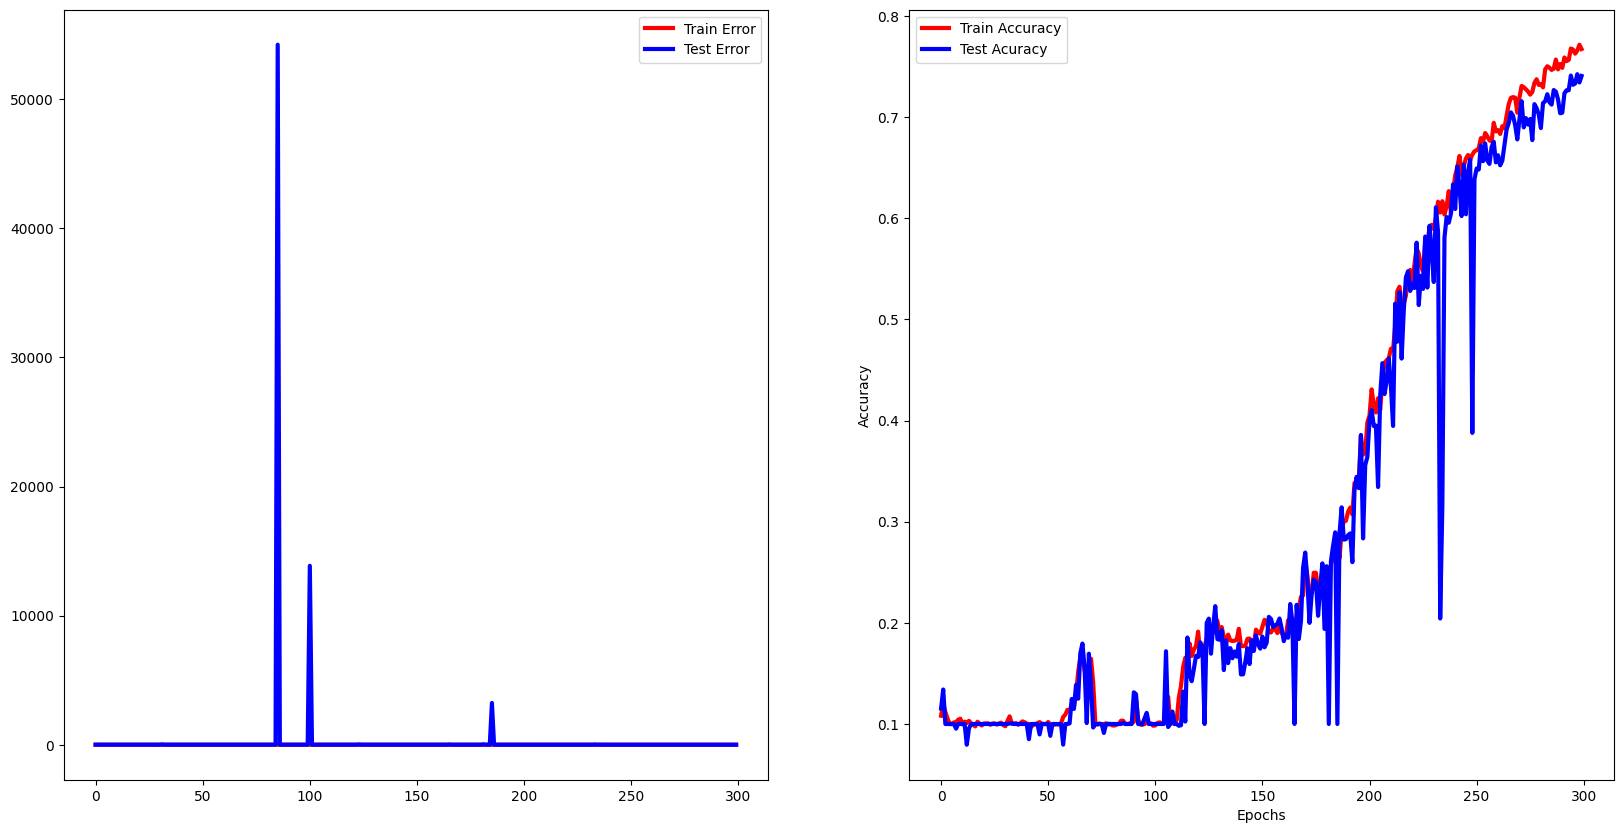

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.7407


In [13]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)
torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 90.0 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

